# Beijing Air Quality Forecasting Starter Notebook

In [47]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [48]:
# reproducibility (best effort)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)

TF version: 2.19.0


In [49]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [51]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [52]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [53]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [54]:
# Check for missing values
print("\nMissing values in training data:")
print(train.isnull().sum())
print("\nMissing values in test data:")
print(test.isnull().sum())


Missing values in training data:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64

Missing values in test data:
No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
dtype: int64


In [55]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


In [56]:
# Drop 'No' column if present
if 'No' in train.columns:
    train = train.drop(['No'], axis=1)
    print("Dropped 'No' column from training data")
if 'No' in test.columns:
    test = test.drop(['No'], axis=1)
    print("Dropped 'No' column from test data")

Dropped 'No' column from training data
Dropped 'No' column from test data


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [57]:
# Separate features and target
X = train.drop(['pm2.5'], axis=1)   # keep all features except pm2.5
y = train['pm2.5']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {X.columns.tolist()}")

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()  # Flatten for sequence creation

print(f"X_scaled shape: {X_scaled.shape}")
print(f"y_scaled shape: {y_scaled.shape}")

# Create sequences for LSTM
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24  # past 24 hours
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

print(f"\nShape of input sequences: {X_seq.shape}")  # (samples, timesteps, features)
print(f"Shape of target: {y_seq.shape}")


# Train-validation split
split = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]

print(f"\nTraining shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

# Ensure y has correct shape for training
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")




Features shape: (30676, 9)
Target shape: (30676,)
Feature columns: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']
X_scaled shape: (30676, 9)
y_scaled shape: (30676,)

Shape of input sequences: (30652, 24, 9)
Shape of target: (30652,)

Training shape: (24521, 24, 9)
Validation shape: (6131, 24, 9)
y_train shape: (24521, 1)
y_val shape: (6131, 1)


In [58]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
# X_train = np.expand_dims(X_train, axis=1)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [59]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(TIME_STEPS, X_scaled.shape[1])),
    Dropout(0.2),
    BatchNormalization(),

    LSTM(64, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),

    Dense(32, activation="relu"),
    Dense(1)  # output layer, predicting pm2.5
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mse",
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 24, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,945 (480.25 KB)

 Trainable params: 122,561 (478.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [60]:
# Train the model with callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)

callbacks = [early_stopping, reduce_lr, checkpoint]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Get final training loss
train_loss = history.history['loss'][-1]


Epoch 1/50
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1580 - root_mean_squared_error: 0.3733

384/384 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - loss: 0.1575 - root_mean_squared_error: 0.3728 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1356 - learning_rate: 0.0010
Epoch 2/50
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0166 - root_mean_squared_error: 0.1286

384/384 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - loss: 0.0166 - root_mean_squared_error: 0.1285 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982 - learning_rate: 0.0010
Epoch 3/50
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0098 - root_mean_squared_error: 0.0989

384/384 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - loss: 0.0098 - root_mean_squared_error: 0.0989 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0957 - learning_rate: 0.0010
Epoch 4/50
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0074 - root_mean_squared_error: 0.0858

384/384 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901 - learning_rate: 0.0010
Epoch 5/50
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799

384/384 ━━━━━━━━━━━━━━━━━━━━ 36s 94ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860 - learning_rate: 0.0010
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0057 - root_mean_squared_error: 0.0758

384/384 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859 - learning_rate: 0.0010
Epoch 7/50
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737

384/384 ━━━━━━━━━━━━━━━━━━━━ 39s 91ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0834 - learning_rate: 0.0010
Epoch 8/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849 - learning_rate: 0.0010
Epoch 9/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855 - learning_rate: 0.0010
Epoch 10/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865 - learning_rate: 0.0010
Epoch 11/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0882 - learning_rate: 0.0010
Epoch 12/50
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0045 - root_mean_squared_

384/384 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0786 - learning_rate: 0.0010
Epoch 13/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800 - learning_rate: 0.0010
Epoch 14/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829 - learning_rate: 0.0010
Epoch 15/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0803 - learning_rate: 0.0010
Epoch 16/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859 - learning_rate: 0.0010
Epoch 17/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - loss: 0.0040 - root_mean_squa

384/384 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0771 - learning_rate: 5.0000e-04
Epoch 21/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - loss: 0.0033 - root_mean_squared_error: 0.0579 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779 - learning_rate: 5.0000e-04
Epoch 22/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step - loss: 0.0033 - root_mean_squared_error: 0.0573 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0775 - learning_rate: 5.0000e-04
Epoch 23/50
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0033 - root_mean_squared_error: 0.0574

384/384 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - loss: 0.0033 - root_mean_squared_error: 0.0574 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0768 - learning_rate: 5.0000e-04
Epoch 24/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - loss: 0.0032 - root_mean_squared_error: 0.0566 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0768 - learning_rate: 5.0000e-04
Epoch 25/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - loss: 0.0032 - root_mean_squared_error: 0.0562 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787 - learning_rate: 5.0000e-04
Epoch 26/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0786 - learning_rate: 2.5000e-04
Epoch 27/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - loss: 0.0029 - root_mean_squared_error: 0.0534 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795 - learning_rate: 2.5000e-04
Epoch 28/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - loss: 0.00

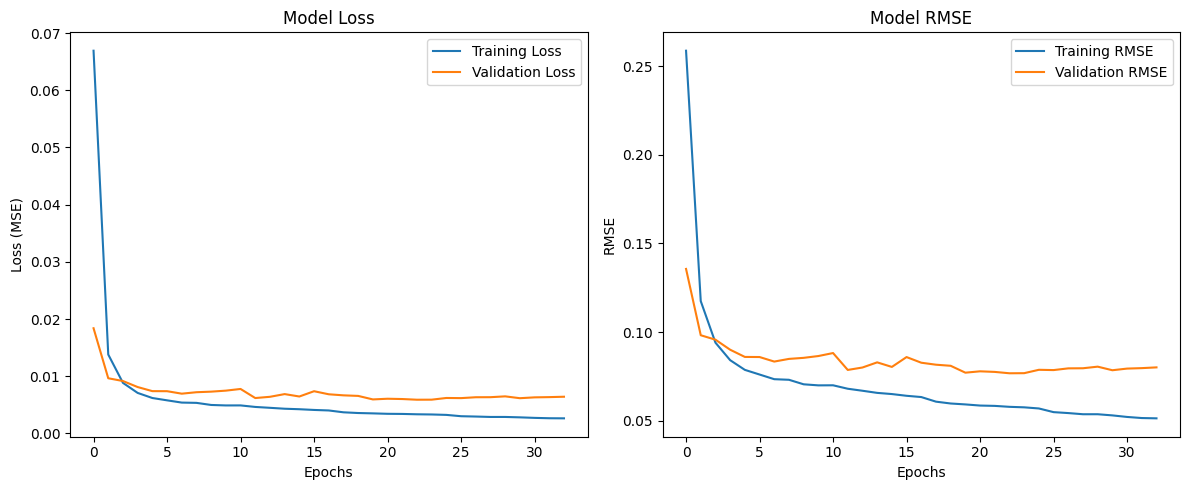

Final Training Loss (MSE): 0.002636514836922288


In [63]:

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Model RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [64]:
# Prepare test data for prediction
print(f"\nTest data columns: {test.columns.tolist()}")

# Scale test features using the same scaler fitted on training data
X_test_scaled = feature_scaler.transform(test)

# Create sequences for test data
# Note: We need to handle the case where we don't have enough historical data
# For simplicity, we'll use the last TIME_STEPS from training data as initial context

# Combine the last part of training data with test data to create proper sequences
combined_data = np.concatenate([X_scaled[-(TIME_STEPS-1):], X_test_scaled], axis=0)

# Create sequences for test data
X_test_seq = []
for i in range(len(X_test_scaled)):
    X_test_seq.append(combined_data[i:(i + TIME_STEPS)])

X_test_seq = np.array(X_test_seq)
print(f"Test sequences shape: {X_test_seq.shape}")

# Make predictions on the test set
predictions_scaled = model.predict(X_test_seq)

# Inverse transform predictions to original scale
predictions = target_scaler.inverse_transform(predictions_scaled)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers (if required by competition)
predictions = np.round(predictions).astype(int)

print(f"Predictions shape: {predictions.shape}")
print(f"Sample predictions: {predictions[:5].flatten()}")

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID'
submission = submission.sort_values(by='row ID')

print(f"\nSubmission shape: {submission.shape}")
print("Sample submission:")
print(submission.head())

# Save the submission file
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/submission.csv', index=False)
print("Submission file saved successfully!")


Test data columns: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']
Test sequences shape: (13148, 24, 9)
411/411 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
Predictions shape: (13148, 1)
Sample predictions: [54 37 18 18 18]

Submission shape: (13148, 2)
Sample submission:
                 row ID  pm2.5
6   2013-07-02 10:00:00     15
7   2013-07-02 11:00:00     16
8   2013-07-02 12:00:00     19
9   2013-07-02 13:00:00     25
10  2013-07-02 14:00:00     56
Submission file saved successfully!
